In [1]:
# set theme
!jt -t oceans16

/bin/bash: jt: command not found


In [2]:
# this is to make the Jupyter notebook as wide as the screen (on the Mac at least)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%config InlineBackend.figure_format ='retina'

# OLTraj Example 2: Lagrangian evolution of a chlorophyll patch

## Objective
To follow the concentration of chlorophyll within a given water mass that moves from its original position.
This is the basics of an analysis in a Lagrangian reference frame and will be compared to the corresponding Eulerian analysis.

## Input data: 

Assume you have identified an interesting chl feature at a given location and time and you want to follow its evolution for 29 days before and 29 days after the observation.

For the Lagrangian analysis you will need: 
1. Satellite (e.g., Ocean Colour - Cliamte Change Initiative) chl images including the intial chl patch as well as areas around it to allow for its advection with time.
2. OLTraj file for the day in which you observed the initial chl patch.

To demonstrate the usefulness of the Lagrangian analysis, we have selected a relatively dynamic region both in chl and in surface currents: i.e., the south west Atlantic.

The initial patch we want to follow is located approximately at xx yy and was observed on January 1st, 2008. 
Thus, the following files are needed for the analysis:
1. OC-CCI chl files before the observation:   
   `../Input/OCCCIv4.2_2007_chl_daily/ESACCI-OC-L3S-CHLOR_A-MERGED-1D_DAILY_4km_GEO_PML_OCx-200712??-fv4.2.nc`
2. OC-CCI chl files after the observation:   
   `../Input/OCCCIv4.2_2008_chl_daily/ESACCI-OC-L3S-CHLOR_A-MERGED-1D_DAILY_4km_GEO_PML_OCx-200801??-fv4.2.nc`
3. OLTraj file:   
   `../Input/20080101_oltraj_025_uv_global.nc`




## Code:

### Import needed modules

In [3]:
import numpy as np
import xarray as xr
import scipy.interpolate as spint
import os
import glob
import datetime as dt
# Plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pandas as pd
import datetime

# import ipdb

### Read OLTraj data

In [73]:

FeEX = True

expand_scale = 1 # [degs]
zoomlon = [139-expand_scale,143+expand_scale]
zoomlat = [-61.5-expand_scale*1,-60+expand_scale*1]



# #### EBUS ##########################################################################
# # define study region
# lonini = -19.5
# dlon = 0.5 # incremnt in longitude (degrees) to define approx area of path
# latini = 22.37
# dlat = 0.35 # increment in latitude (degrees) to define approx area of path
# chl_thresh = 1.
# idate = dt.datetime(2018,12,10)
# # parameters to subset OC-CCI data
# region = {'name':'EBUS_region','lonmin':-30 ,'lonmax':-15, 'latmin':15,'latmax':25}
# var_list = ['chlor_a']
# # temporal slice
# tslice1 = "2018-11-25"
# tslice2 = "2019-01-08"
# #############################################################################



#### east of Madagascar ##########################################################################
# define study region

# parameters to subset OC-CCI data
region = {'name':'SE_Madagascar','lonmin':55 ,'lonmax':70, 'latmin':-32,'latmax':-24}
var_list = ['chlor_a']
chl_min = 0.02 # [mg/m3] this is for plotting
chl_max = 1. # [mg/m3] this is for plotting

lonini = region['lonmin'] + (region['lonmax']-region['lonmin'])/2.
dlon = 1. # incremnt in longitude (degrees) to define approx area of path. 
latini = region['latmin'] + (region['latmax']-region['latmin'])/2.
dlat = 5. # increment in latitude (degrees) to define approx area of path


###### coordinates of water parcel to follow
# # temporal slice
# idate = dt.datetime(2006,2,10)
# tslice1 = "2006-02-01"
# tslice2 = "2006-03-31"
# patch_lonini = 56.079
# patch_dlon = 1. # incremnt in longitude (degrees) to define approx area of path. 
# patch_latini = -29.9
# patch_dlat = 1. # increment in latitude (degrees) to define approx area of path
# chl_thresh = 0.3 # [mg/m3] used to see OLTraj particles

# # temporal slice
# idate = dt.datetime(2006,2,10)
# tslice1 = "2006-02-01"
# tslice2 = "2006-03-31"
# patch_lonini = 60.48
# patch_dlon = 1.75 # incremnt in longitude (degrees) to define approx area of path. 
# patch_latini = -23.56
# patch_dlat = 0.8 # increment in latitude (degrees) to define approx area of path
# chl_thresh = 0.2 # [mg/m3] used to see OLTraj particles

# # temporal slice
# idate = dt.datetime(2006,2,1)
# tslice1 = "2006-01-01"
# tslice2 = "2006-03-31"
# patch_lonini = 63.466
# patch_dlon = 2. # incremnt in longitude (degrees) to define approx area of path. 
# patch_latini = -28.386
# patch_dlat = 1 # increment in latitude (degrees) to define approx area of path
# chl_thresh = 0.2 # [mg/m3] used to see OLTraj particles



# temporal slice
idate = dt.datetime(2006,1,16)
tslice1 = (idate - dt.timedelta(days=29)).strftime("%Y-%m-%d")  # maximum start date set at 29 days before idate
tslice2 = (idate + dt.timedelta(days=29)).strftime("%Y-%m-%d")  # maximum end date set at 29 days before idate
patch_lonini = 60.8
patch_dlon = 1.2 # increment in longitude (degrees) to define approx area of path. 
patch_latini = -28.9
patch_dlat = 1. # increment in latitude (degrees) to define approx area of path
chl_thresh = 0.075 # [mg/m3] used to see OLTraj particles
#############################################################################





strdate = idate.strftime('%Y-%m-%d')

dtime = 29

centre_lon = zoomlon[0]+np.diff(zoomlon)/2







In [74]:
#### convert longitude to -180,180 degs
def convLon(ds):
    import copy

    # find middle point of longitude
    imid = np.where(ds_OLT.lon==180.)[0][0]
    # then find the first negarive longitude
    i1stnegatinve = imid + 1
    
#     # this is when lon=[0:360]
#     new_lon = ((ds['lon'].values + 180) % 360) - 180
#     lon = np.append(new_lon[i1stnegatinve:], new_lon[:i1stnegatinve] )
#     ds['lon'] = lon

    # this is for when lon=[1:180,-180:0]
    new_lon = ds['lon'].values
    lon = np.append(new_lon[i1stnegatinve:], new_lon[:i1stnegatinve] )
    ds['lon'] = lon

    
    #### shift trajlon array
    tmp = copy.deepcopy(ds['trajlon'].values)
    tmp2 = np.append(tmp[:,:,i1stnegatinve:], tmp[:,:,   :i1stnegatinve], axis=2)
    ds['trajlon'][:,:,:] = tmp2

    #### shift trajlat array
    del tmp, tmp2
    tmp = copy.deepcopy(ds['trajlat'].values)
    tmp2 = np.append(tmp[:,:,i1stnegatinve:], tmp[:,:,   :i1stnegatinve], axis=2)
    ds['trajlat'][:,:,:] = tmp2

    return ds

#### Read OLTraj data

In [75]:
# DIN_AVISO = '/data/datasets/Projects/OLTraj/From_AVISO/OLTraj/Processed/Lagrangian_traj/'
DIN_AVISO = '/data/datasets/Projects/OLTraj/From_AVISO/OLTraj/Processed/Lagrangian_traj/'
fn_OLT = DIN_AVISO + f'{idate.strftime("%Y")}/{idate.strftime("%Y%m%d")}_oltraj_uv_global.nc'

# open OLTraj file
ds_OLT = xr.open_dataset(fn_OLT)

# # convert longitude to to -180,180 degs
# if ds_OLT['lon'].values.min()>0:
#     ds_OLT = convLon(ds_OLT)

# ds_OLT = convLon(ds_OLT)   

# subset OLTraj dataframe    
ds_OLT_patch = ds_OLT.loc[ { 'lat': slice(patch_latini-patch_dlat, patch_latini+patch_dlat), 
                             'lon': slice(patch_lonini-patch_dlon,  patch_lonini+patch_dlon),     
                           }  ]    


In [76]:
# set appropriate attributes for OLTraj (needed for plotting)
ds_OLT_patch['time'].attrs["standard_name"] = "time"
ds_OLT_patch['time'].attrs["axis"] =  "T"



### Read chl data

In [77]:
# open dataset over the internet
GEO_DAILY_THREDDS_string = 'https://rsg.pml.ac.uk/thredds/dodsC/CCI_ALL-v5.0-DAILY'
all_data = xr.open_dataset(GEO_DAILY_THREDDS_string)

# read subsetted data
ds_CHL = all_data[var_list].loc[ {  'time': slice(tslice1, tslice2), 
                                    'lat': slice(region['latmax'], region['latmin']), 
                                    'lon': slice(region['lonmin'], region['lonmax'])}  ]    

### Plot map with initial observation

/users/modellers/gdal/miniconda3/envs/OLTraj_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/users/modellers/gdal/miniconda3/envs/OLTraj_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '


/users/modellers/gdal/miniconda3/envs/OLTraj_env/lib/python3.8/site-packages/cartopy/crs.py:785: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return_value = vertices + [[-offset, 0]]


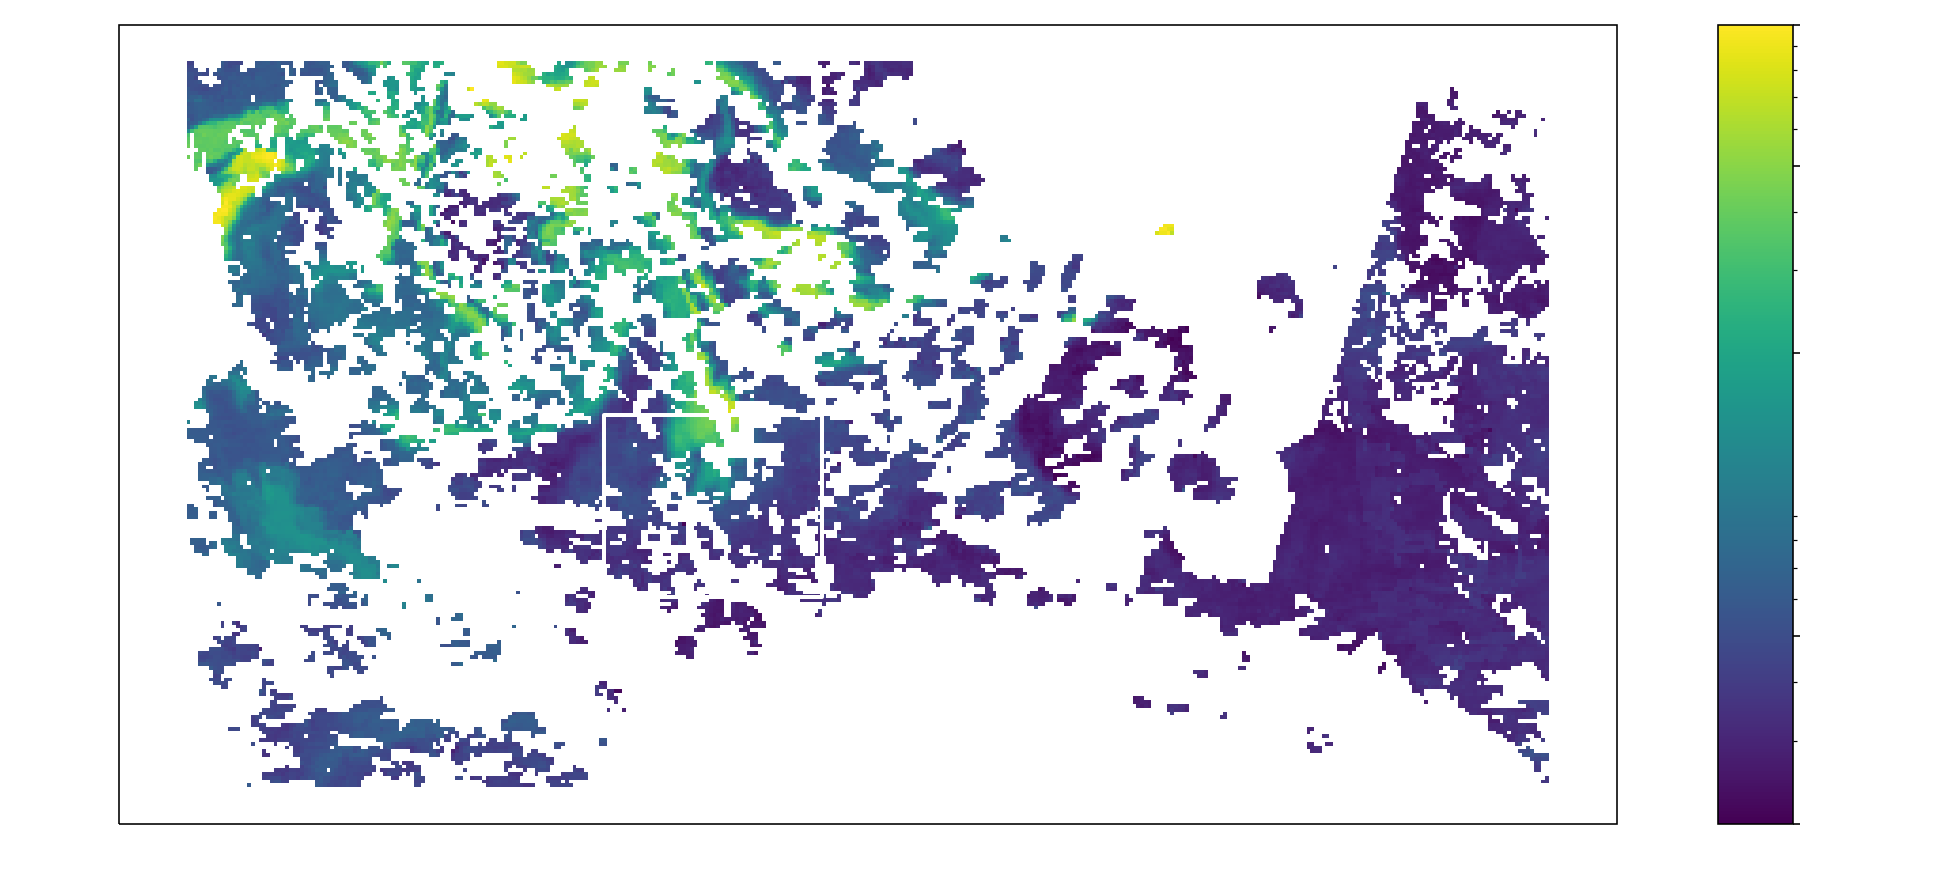

In [78]:
fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(111, projection=ccrs.PlateCarree(  central_longitude=centre_lon   )  )

# extract chl at the time of observation
CHL_t0 = ds_CHL['chlor_a'].sel(time=strdate)

# plot chl on a log scale
pc = ax.pcolormesh(  CHL_t0['lon'], CHL_t0['lat'], CHL_t0, transform=ccrs.PlateCarree(central_longitude=centre_lon), norm=colors.LogNorm(vmin=chl_min, vmax=chl_max)  )

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='w', facecolor='darkgray'))
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabel_style = {'size': 14, 'color': 'w'}
gl.ylabel_style = {'size': 14, 'color': 'w'}
gl.ylabels_right = False
gl.xlabels_top = False

ts = pd.to_datetime(str(CHL_t0.time.values)) 
d = ts.strftime('%Y-%m-%d')
# ax.set_title(d+"\n", fontsize=20, color="w")

divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.7, axes_class=plt.Axes)

fig.add_axes(ax_cb)
cb = plt.colorbar(pc, cax=ax_cb)
cb.set_label('Chl [mg m$^{-3}$]', color="w", fontsize=20)
cb.ax.autoscale(False)
cb.set_ticks([0.02, 0.05, 0.2, 0.5, 1])
cb.ax.set_yticklabels(["0.02", "0.05", "0.2", "0.5", "1"], color="w", fontsize=14)


ax.plot([patch_lonini-patch_dlon, patch_lonini+patch_dlon, patch_lonini+patch_dlon, patch_lonini-patch_dlon, patch_lonini-patch_dlon],
        [patch_latini-patch_dlat, patch_latini-patch_dlat, patch_latini+patch_dlat, patch_latini+patch_dlat, patch_latini-patch_dlat], 
        lw=2, c='w',transform=ccrs.PlateCarree(central_longitude=centre_lon))





### Identify trajectories within patch
To do that, we select trajectories that are within the black square with chl values smaller than chl_thresh.

**Importantly**, we need to interpolate the chl data onto the same spatial grid as the OLTraj data.


In [79]:
# function to interpolate chl field onto OLTraj product at a given time
# Crucial point: in this example, and in this fuction, we assume that chl and OLTraj share the same time coordinate 
def interp_chl_on_OLTraj(ds_CHL, ds_OLT, interp_time):
    # ds_CHL: xarray dataset with the chl data (if working on a small region, slice these arrays before this function to speed things up)
    # ds_OLT: xarray dataset with the OLTraj product
    # interp_time: date string at which we want the interpolated chl onto the OLTraj geographic coordinate
    
    # Since input field is on a regular grid but the trajectory positions are not,
    # we can use RegularGridInterpolator from scipy.interpolate
    
    # Slice chl data closest to the given time (see xarray documentation for "closest")
    CHL_it = ds_CHL['chlor_a'].sel(time=interp_time)
    
    # Extract chl coordinates 
    lonCHL = CHL_it['lon'].values
    latCHL = CHL_it['lat'].values
    
    # Need to flip lat and chl matrix because OCCCI lat are in descending order
    latCHL = np.flipud(latCHL)
    CHL = np.flipud(CHL_it.values)

    # Create the interpolation function
    finterp = spint.RegularGridInterpolator((latCHL,lonCHL),CHL,method='linear')
        
    # extract OLTraj data closest to the given time (see xarray documentation for "closest")
    latOLT = ds_OLT['trajlat'].sel(time=interp_time).values
    lonOLT = ds_OLT['trajlon'].sel(time=interp_time).values

    # Get lat and lon dimensions used later to reshpe 1d array and 2d array
    londim = ds_OLT['lon'].shape
    latdim = ds_OLT['lat'].shape
    
    # Convert 2D OLTraj coordinates into 1D arrays
    latOLT = latOLT.ravel()
    lonOLT = lonOLT.ravel()

    # Interpolate Chl over trajectory positions
    intCHL = finterp(np.array([latOLT,lonOLT]).T) # Need to transpose to have lat and lon as columns of the input matrix
    
    # Convert into 2D matrix
    intCHL = intCHL.reshape(latdim+londim)
    
    return intCHL 

In [80]:
# Interpolate Chl on trajectory positions at given date
znew = interp_chl_on_OLTraj(ds_CHL, ds_OLT_patch, strdate)

znew_shp = np.asarray(znew.shape)
# igood = np.where(np.zeros((znew_shp[0]-1, znew_shp[1]))==np.zeros((znew_shp[0]-1, znew_shp[1])  )   ) # here I create an array of the same size as znew, but with all non-nan elements
igood = np.where(znew > chl_thresh)

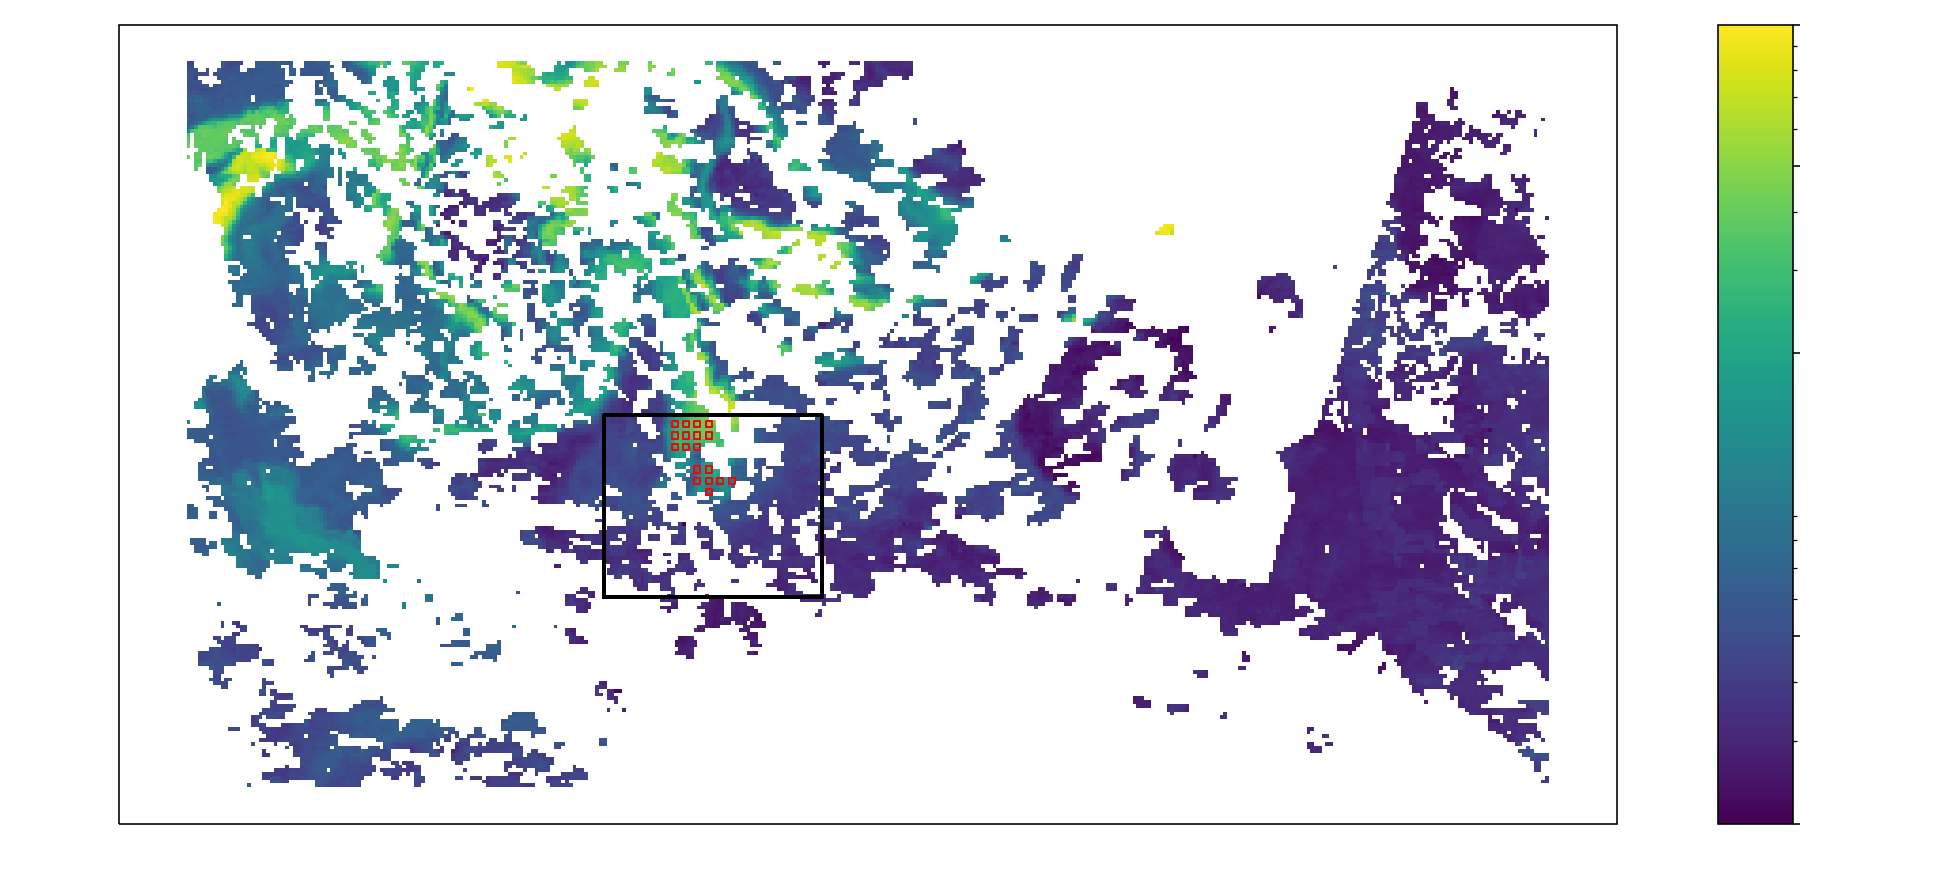

In [81]:
fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(111, projection=ccrs.PlateCarree(  central_longitude=centre_lon   )  )

# extract chl at the time of observation
CHL_t0 = ds_CHL['chlor_a'].sel(time=strdate)

# plot chl on a log scale
pc = ax.pcolormesh(  CHL_t0['lon'], CHL_t0['lat'], CHL_t0, transform=ccrs.PlateCarree(central_longitude=centre_lon), norm=colors.LogNorm(vmin=chl_min, vmax=chl_max)  )

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='w', facecolor='darkgray'))
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabel_style = {'size': 14, 'color': 'w'}
gl.ylabel_style = {'size': 14, 'color': 'w'}
gl.ylabels_right = False
gl.xlabels_top = False

ts = pd.to_datetime(str(CHL_t0.time.values)) 
d = ts.strftime('%Y-%m-%d')
# ax.set_title(d+"\n", fontsize=20, color="w")

divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.7, axes_class=plt.Axes)

fig.add_axes(ax_cb)
cb = plt.colorbar(pc, cax=ax_cb)
cb.set_label('Chl [mg m$^{-3}$]', color="w", fontsize=20)
cb.ax.autoscale(False)
cb.set_ticks([0.02, 0.05, 0.2, 0.5, 1])
cb.ax.set_yticklabels(["0.02", "0.05", "0.2", "0.5", "1"], color="w", fontsize=14)


ax.scatter(ds_OLT_patch['trajlon'].values[29,igood[0],igood[1]], 
           ds_OLT_patch['trajlat'].values[29,igood[0],igood[1]], marker="s", s=10,
           transform=ccrs.PlateCarree(central_longitude=centre_lon), 
           facecolor='none', edgecolors="r", zorder=60)

ax.plot([patch_lonini-patch_dlon,patch_lonini+patch_dlon,patch_lonini+patch_dlon,patch_lonini-patch_dlon,patch_lonini-patch_dlon],
        [patch_latini-patch_dlat,patch_latini-patch_dlat,patch_latini+patch_dlat,patch_latini+patch_dlat,patch_latini-patch_dlat], 
        lw=2, c='k',transform=ccrs.PlateCarree(central_longitude=centre_lon))



**Now we plot the backward (pink) and forward (cyan) trajectories on top of the chl image at the time of observation to see where the patch came from and where it is going to move**

/users/modellers/gdal/miniconda3/envs/OLTraj_env/lib/python3.8/site-packages/cartopy/crs.py:785: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return_value = vertices + [[-offset, 0]]


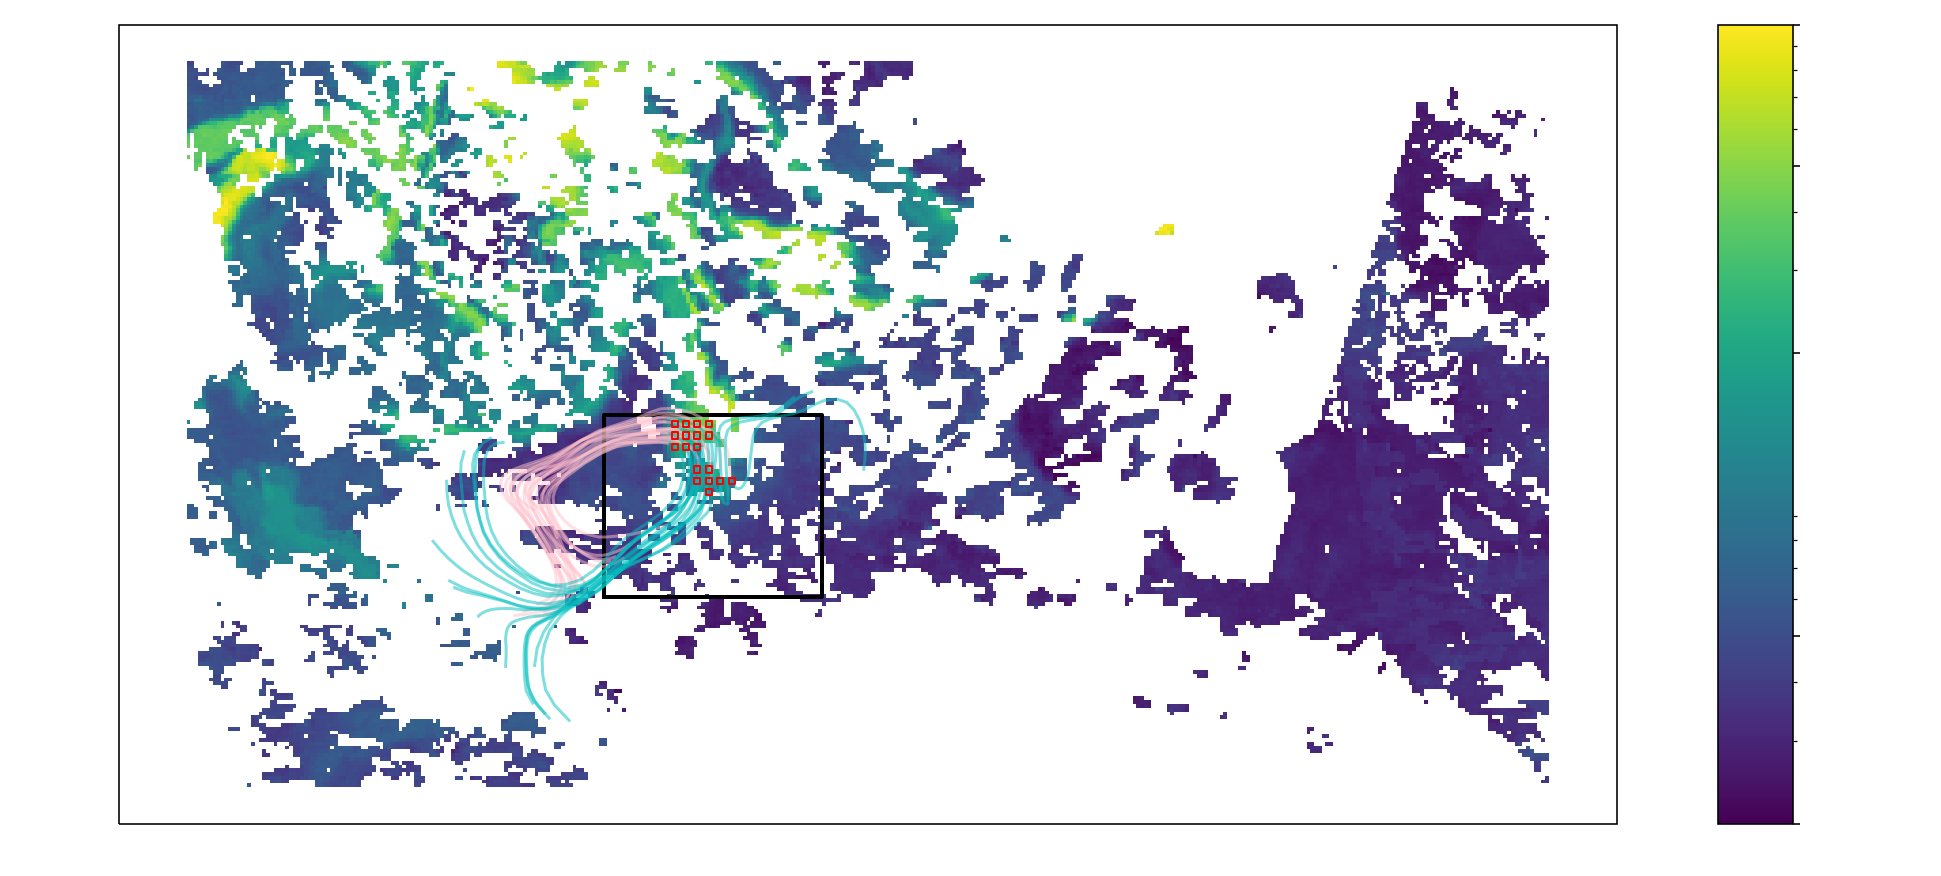

In [82]:
fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(111, projection=ccrs.PlateCarree(  central_longitude=centre_lon   )  )

# extract chl at the time of observation
CHL_t0 = ds_CHL['chlor_a'].sel(time=strdate)

# plot chl on a log scale
pc = ax.pcolormesh(  CHL_t0['lon'], CHL_t0['lat'], CHL_t0, transform=ccrs.PlateCarree(central_longitude=centre_lon), norm=colors.LogNorm(vmin=chl_min, vmax=chl_max)  )

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='w', facecolor='darkgray'))
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabel_style = {'size': 14, 'color': 'w'}
gl.ylabel_style = {'size': 14, 'color': 'w'}
gl.right_labels = False
gl.top_labels = False

ts = pd.to_datetime(str(CHL_t0.time.values)) 
d = ts.strftime('%Y-%m-%d')
# ax.set_title(d+"\n", fontsize=20, color="w")

divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.7, axes_class=plt.Axes)

fig.add_axes(ax_cb)
cb = plt.colorbar(pc, cax=ax_cb)
cb.set_label('Chl [mg m$^{-3}$]', color="w", fontsize=20)
cb.ax.autoscale(False)
cb.set_ticks([0.02, 0.05, 0.2, 0.5, 1])
cb.ax.set_yticklabels(["0.02", "0.05", "0.2", "0.5", "1"], color="w", fontsize=14)


ax.scatter(ds_OLT_patch['trajlon'].values[29,igood[0],igood[1]], 
           ds_OLT_patch['trajlat'].values[29,igood[0],igood[1]], marker="s", s=10,
           transform=ccrs.PlateCarree(central_longitude=centre_lon), 
           facecolor='none', edgecolors="r", zorder=60)

ax.plot([patch_lonini-patch_dlon,patch_lonini+patch_dlon,patch_lonini+patch_dlon,patch_lonini-patch_dlon,patch_lonini-patch_dlon],
        [patch_latini-patch_dlat,patch_latini-patch_dlat,patch_latini+patch_dlat,patch_latini+patch_dlat,patch_latini-patch_dlat], 
        lw=2, c='k',transform=ccrs.PlateCarree(central_longitude=centre_lon));

ax.plot(ds_OLT_patch['trajlon'].values[0:29,igood[0],igood[1]], 
           ds_OLT_patch['trajlat'].values[0:29,igood[0],igood[1]], 
           transform=ccrs.PlateCarree(central_longitude=centre_lon), 
           color='pink', alpha=0.5);

ax.plot(ds_OLT_patch['trajlon'].values[29:,igood[0],igood[1]], 
           ds_OLT_patch['trajlat'].values[29:,igood[0],igood[1]], 
           transform=ccrs.PlateCarree(central_longitude=centre_lon), 
           color='c', alpha=0.5);


In [83]:
itime = np.arange(0,ds_CHL['chlor_a'].shape[0],1)
itime.shape

(59,)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
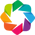

:DynamicMap   [time]
   :Overlay
      .Image.I   :Image   [lon,lat]   (chlor_a)
      .Points.I  :Points   [lon,lat]
      .Points.II :Points   [lon,lat]

In [84]:
import holoviews as hv
from holoviews import opts
import hvplot.pandas
import hvplot.xarray

hv.extension('bokeh')

startdate = tslice1
enddate = tslice2


# convert ds_OLT_patch to a pandas DataFrame
trajlat = ds_OLT_patch.sel(time = slice(startdate, enddate)).trajlat.values[:,igood[0], igood[1]]
trajlon = ds_OLT_patch.sel(time = slice(startdate, enddate)).trajlon.values[:,igood[0], igood[1]]
time = pd.to_datetime(ds_OLT_patch.sel(time = slice(startdate, enddate)).time.values) #- dt.timedelta(days=1)


# initialize datetime64 array of the same size as trajlon
tmp = np.Datetime64().astype('M8[ns]')
t64 = np.tile(tmp, [trajlon.shape[0], trajlon.shape[1]])

# fill datetime64 array with times
for ic in range(trajlon.shape[1]):
    t64[:,ic] = time


# create a pandas dataframe for oltraj dataset
olt_pd = pd.DataFrame({"lat" : np.ravel(trajlat), 
                   "lon" : np.ravel(trajlon), 
                   "time": np.ravel(t64) 
                  })        


#### create overlay of two datasets
# create chl object
chl_hv = ds_CHL.sel(time=slice(startdate, enddate)).\
        hvplot( groupby='time', logz=True, colorbar=True,  cmap='viridis').\
                redim.range(lon = (55, 70), 
                            lat = (-32,  -24),
                            chlor_a = (chl_min, chl_max), 
                           )
# create OLT object of central date
t_default = np.datetime64(idate)
olt_hv0 = olt_pd.loc[(olt_pd['time']==t_default)].\
            hvplot.points('lon', 'lat', marker='s', line_color='k', line_width=0.5, fill_alpha=0, size=15)  




# create olt object
olt_hv = olt_pd.hvplot.points('lon', 'lat', groupby='time', marker='s', line_color='red', line_width=0.5, fill_alpha=0, size=15)  

# create overlay
overlay = chl_hv * olt_hv0 * olt_hv

# set location of slider to below the plot
hv.output(widget_location='bottom')


# set size of plot and starting time, and visualise
overlay.opts( width = 800, 
              height = 400).redim.default(time=t_default)




In [260]:
# Interpolate ds_CHL on the OLT positions at each timestep
# We need to use the full chl field because particles might be advected outside the chl domain used for the plot
# (in that case the interpolation function would return an error)
for ii, it in enumerate(ds_CHL['time'].values):
    _ds_CHL_OLT = interp_chl_on_OLTraj(ds_CHL, ds_OLT_patch, it)
    if ii == 0:
        ds_CHL_OLT = _ds_CHL_OLT[None,...]
    else:
        ds_CHL_OLT = np.concatenate((ds_CHL_OLT, _ds_CHL_OLT[None,...]), axis=0)

# Select only particles within the area and the given chl threshold
ds_CHL_OLT = ds_CHL_OLT[:, igood[0], igood[1]]



/users/modellers/gdal/miniconda3/envs/OLTraj_env/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/users/modellers/gdal/miniconda3/envs/OLTraj_env/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


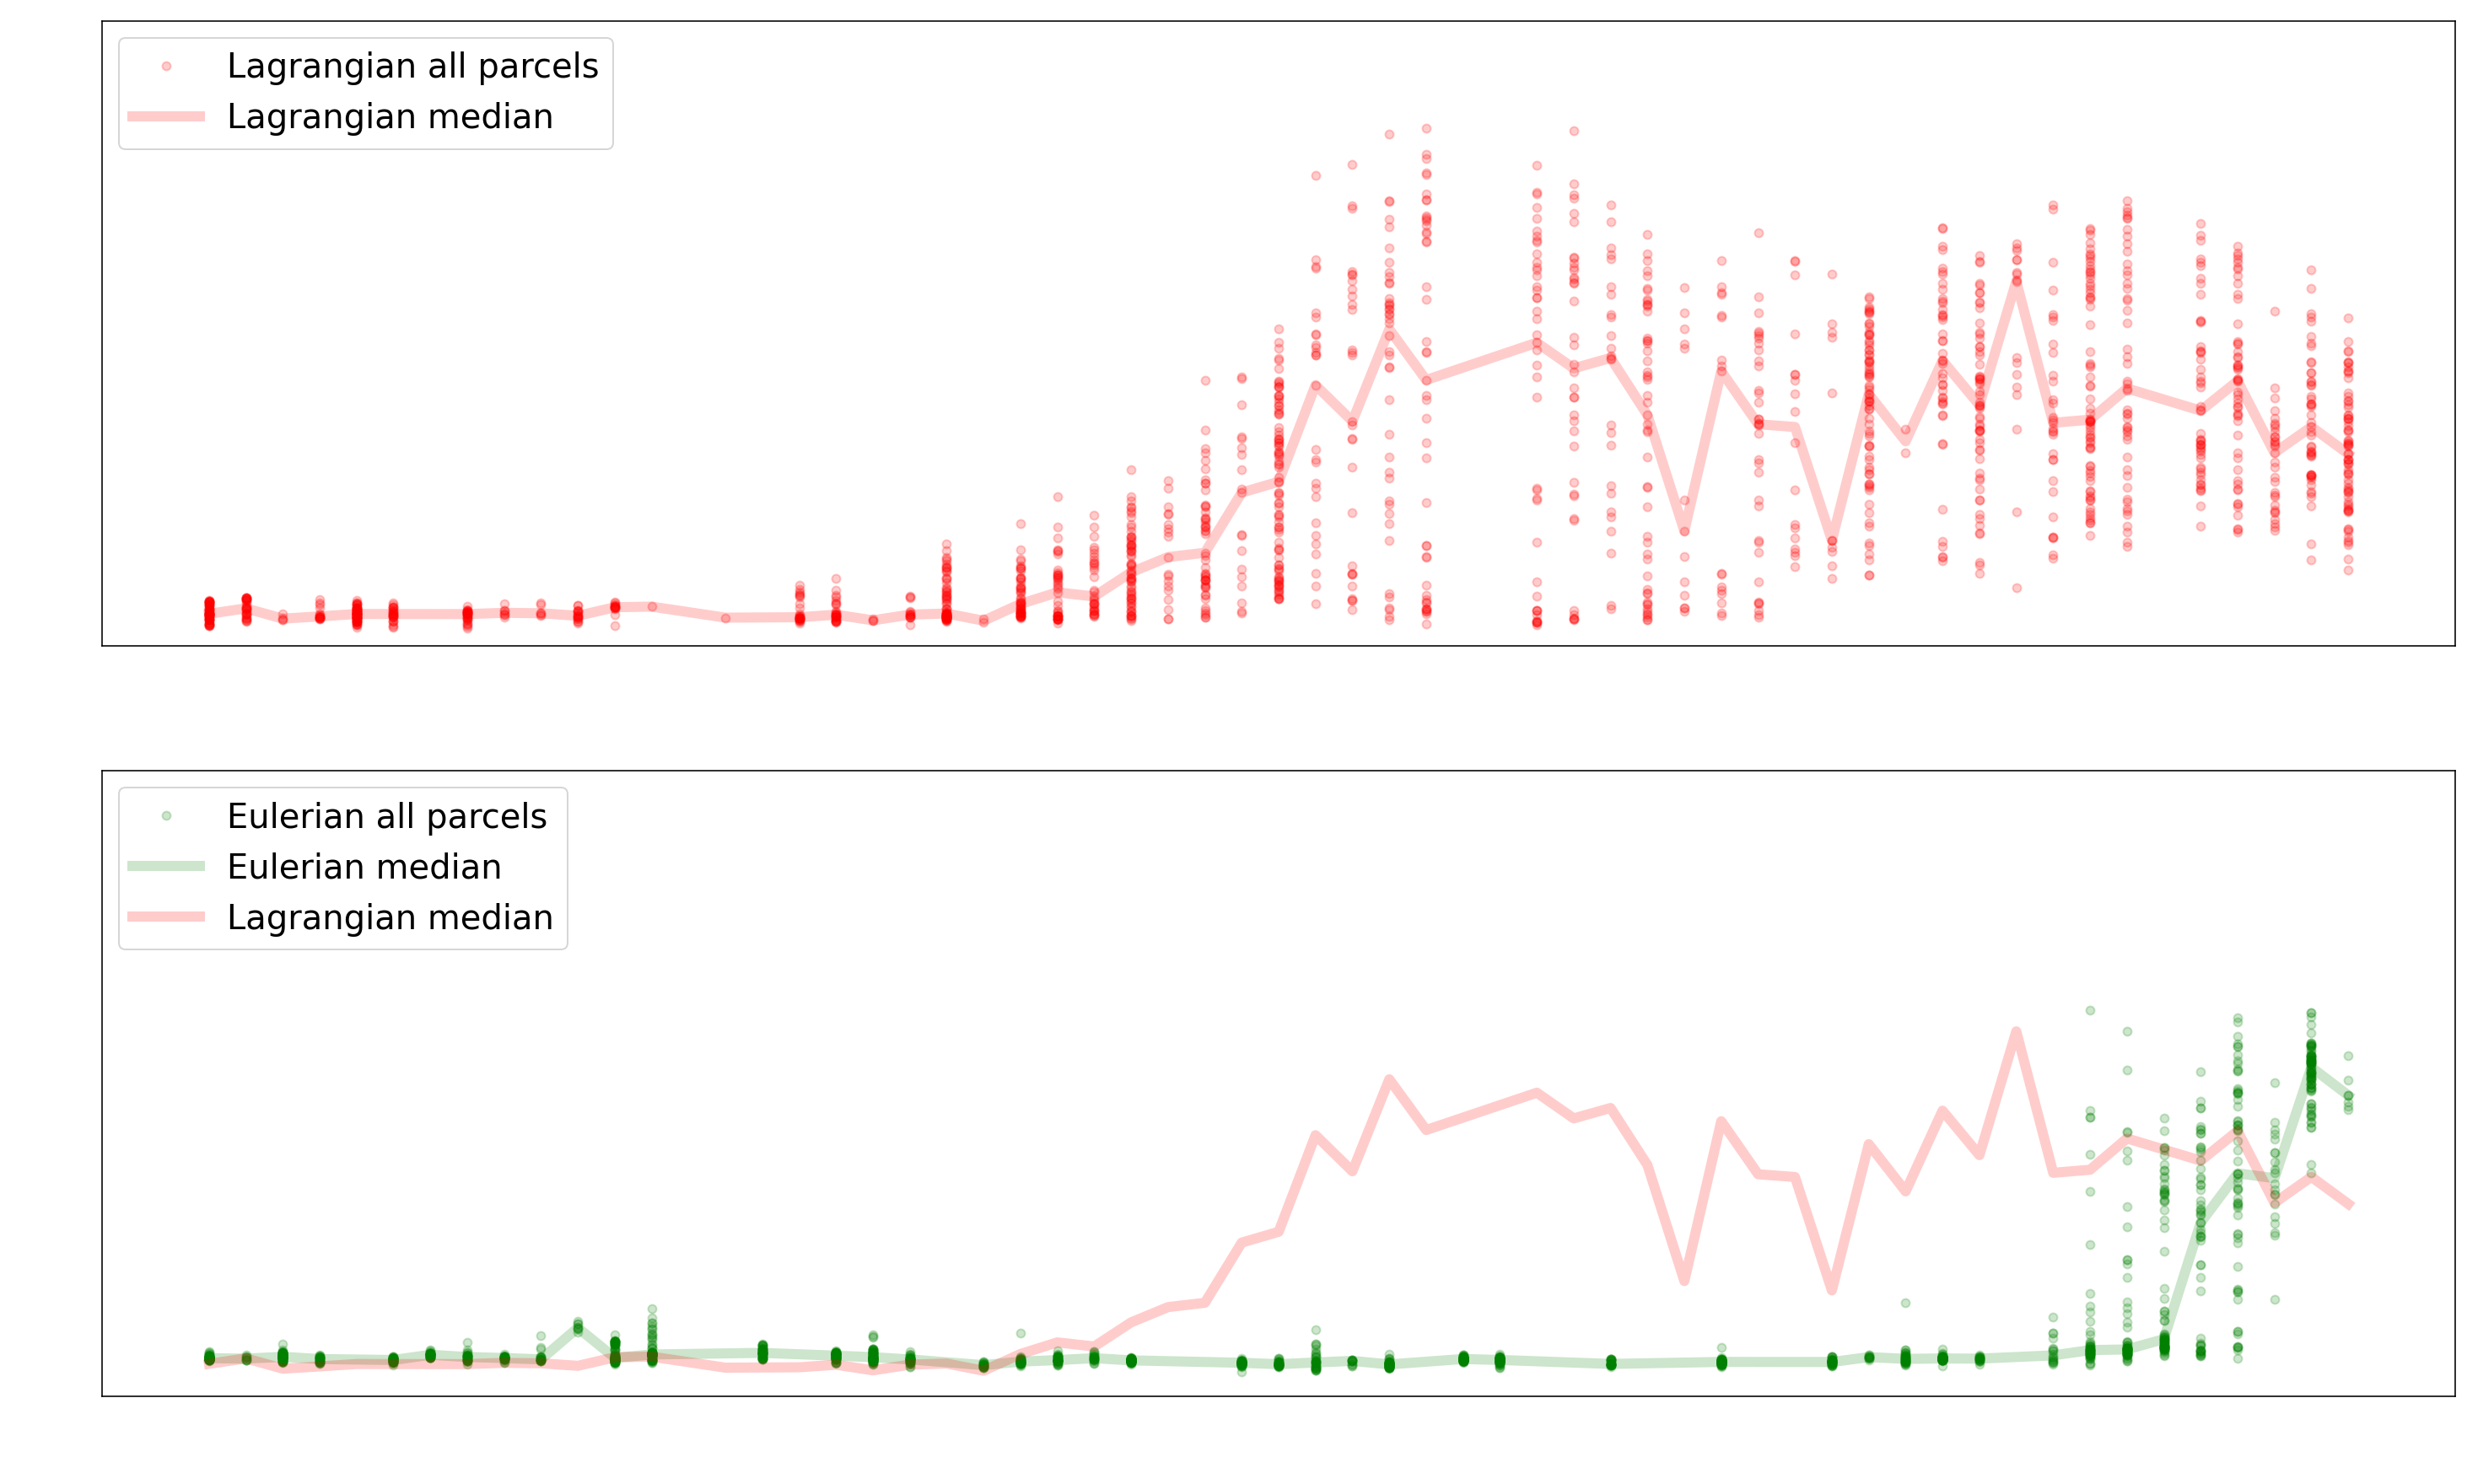

In [281]:
fig = plt.figure(figsize=(25,15))
ax = fig.add_subplot(211)

# pl = ax.plot(ds_CHL['time'], ds_CHL_OLT,'bo', label='Lagrangian all parcels')
# pl = ax.plot(ds_CHL['time'][29], ds_CHL_OLT[[29],:], 'bo', zorder=60)

# CHL_OLT_med = np.nanmedian(ds_CHL_OLT, axis=1)
# inan1 = np.isnan(CHL_OLT_med)
# CHL_OLT_med = CHL_OLT_med[~inan1]
# pl = ax.plot(ds_CHL['time'][~inan1], CHL_OLT_med,'b', label='Lagrangian Median')
# ax.set_ylim(0,2)

# compute median
CHL_OLT_med = np.nanmedian(ds_CHL_OLT,axis=1)
inan2 = np.isnan(CHL_OLT_med)
CHL_OLT_med = CHL_OLT_med[~inan2]

ax.plot(ds_CHL['time'], ds_CHL_OLT, 'ro', label='Lagrangian all parcels', ms=5, alpha=0.2)
ax.plot(ds_CHL['time'][~inan2], CHL_OLT_med, 'r', label='Lagrangian median', lw=6, alpha=0.2)
ax.set_ylim(0,1)

ax.set_xlabel("date", fontsize=20, color='w')
ax.set_ylabel("Chl [mg m$^{-3}$]", fontsize=20, color='w')
ax.tick_params(axis='x', colors='w')
ax.tick_params(axis='y', colors='w')
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)

ax.legend(fontsize=20)

# this is to only plot the legend for the median value
# extract from the legend labels only the median values
handles, labels = ax.get_legend_handles_labels()
# n_lag = ds_CHL_OLT.shape[1] 
# ax.legend(handles[n_lag::n_lag+1], labels[n_lag::n_lag+1], fontsize=20)
ax.legend(handles[-2:], labels[-2:], fontsize=20, loc='upper left')



### Plot Eulerian time series
ax2 = fig.add_subplot(212)

# extract Eulerian time series
ds_CHL_Eul = ds_CHL.sel(lon=slice(lonini-dlon,lonini+dlon),lat=slice(latini+dlat,latini-dlat))
ds_CHL_Eul = ds_CHL_Eul['chlor_a'].values
ds_CHL_Eul = ds_CHL_Eul[:,igood[0],igood[1]]

# compute median
CHL_Eul_med = np.nanmedian(ds_CHL_Eul,axis=1)
inan = np.isnan(CHL_Eul_med)
CHL_Eul_med = CHL_Eul_med[~inan]

ax2.plot(ds_CHL['time'],ds_CHL_Eul,'go', label='Eulerian all parcels', ms=5, alpha=0.2)
# ax.plot(ds_CHL['time'][29],ds_CHL_Eul[[29],:], 'ro')
ax2.set_ylim(0,1)

ax2.plot(ds_CHL['time'][~inan], CHL_Eul_med, 'g', label='Eulerian median', lw=6, alpha=0.2)
ax2.plot(ds_CHL['time'][~inan1], CHL_OLT_med, 'r', label='Lagrangian median', lw=6, alpha=0.2)


ax2.set_xlabel("date", fontsize=20, color='w')
ax2.set_ylabel("Chl [mg m$^{-3}$]", fontsize=20, color='w')
ax2.tick_params(axis='x', colors='w')
ax2.tick_params(axis='y', colors='w')
plt.setp(ax2.get_xticklabels(), fontsize=14)
plt.setp(ax2.get_yticklabels(), fontsize=14)

# this is to only plot the legend for the median value
# extract from the legend labels only the median values
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[-3:], labels[-3:], fontsize=20, loc='upper left')
